<a href="https://www.kaggle.com/code/anshulm257/mushroom-edibility-eda-ensemble-0-98530?scriptVersionId=196527603" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

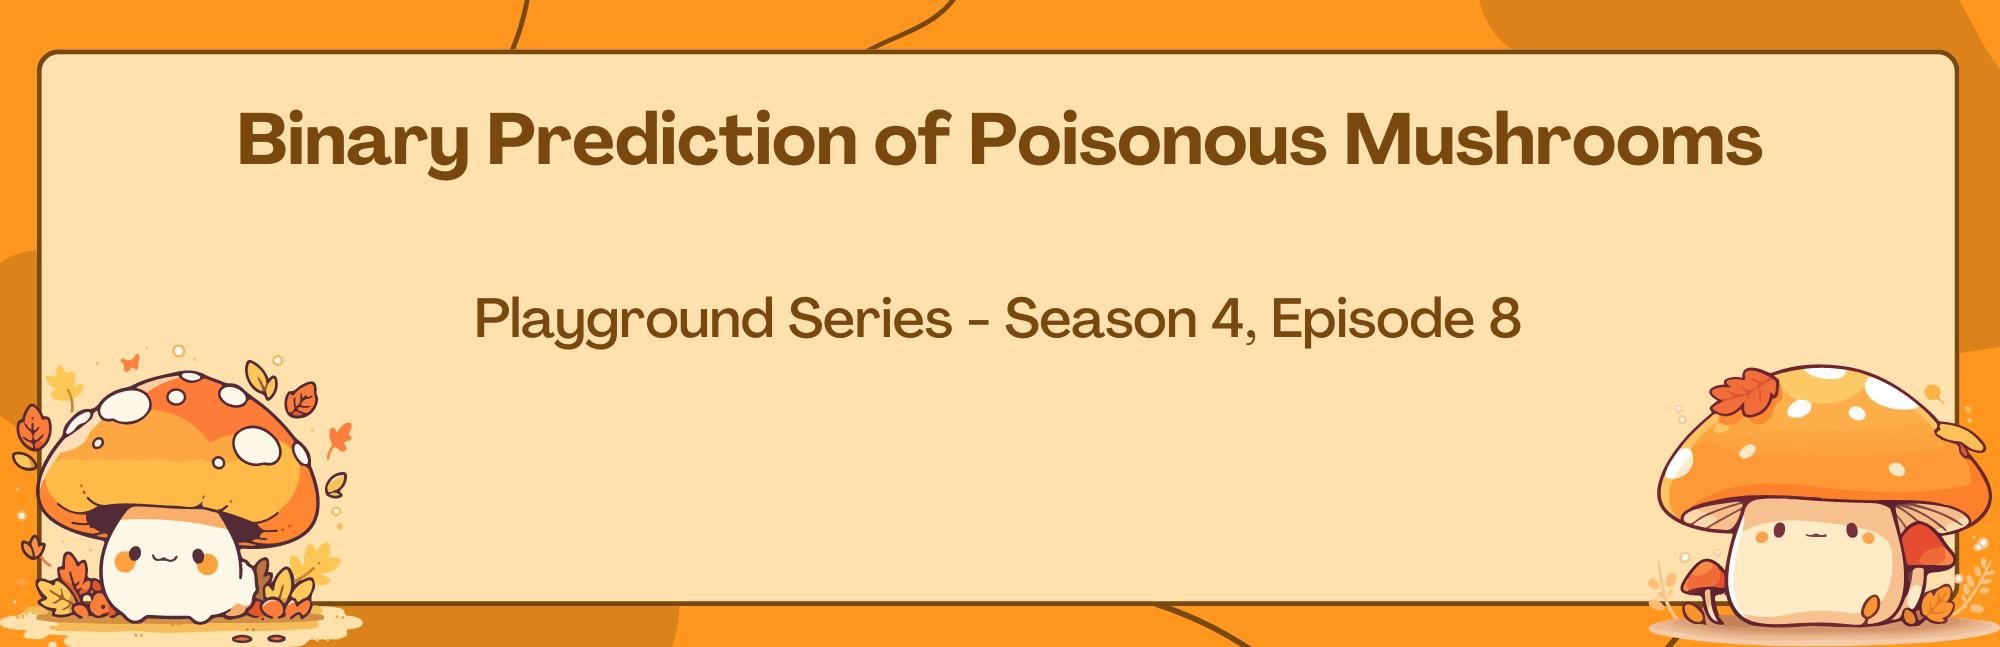

<p style="text-align: center; font-size: 20px; background-color: #90EE90; font-family: 'Comic Sans MS', cursive; padding: 20px; border-radius: 10px; box-shadow: 0 4px 6px rgba(0, 0, 0, 0.1); color: #3A6AB7;">
  In this notebook, we examine the Mushroom dataset with the goal of binary prediction for poisonous mushrooms. We begin with an in-depth Exploratory Data Analysis (EDA) to identify important patterns and relationships. Next, we enhance our dataset through strategic feature engineering, setting the stage for effective modeling. Finally, we apply the XGBoost and LGBM algorithms, and ensemble them to build a robust predictive model, focusing on its technical implementation and performance.
</p>


In [1]:
!pip install -q ucimlrepo

## Import libraries 📚

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import warnings
from sklearn.base import clone
from ucimlrepo import fetch_ucirepo 
from sklearn.base import clone
from xgboost import XGBClassifier
import pickle
from sklearn.base import clone
import gc
from matplotlib.colors import LinearSegmentedColormap
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier, Pool
from lightgbm.callback import early_stopping, log_evaluation
from catboost import CatBoostClassifier
from sklearn.metrics import matthews_corrcoef
from scipy.stats import mode

warnings.filterwarnings("ignore")

from sklearn.impute import SimpleImputer
from sklearn.model_selection import StratifiedKFold, train_test_split, cross_val_score, cross_validate
from sklearn.metrics import matthews_corrcoef, f1_score, confusion_matrix, ConfusionMatrixDisplay, make_scorer
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.pipeline import make_pipeline, Pipeline


from xgboost import XGBClassifier

In [3]:
TARGET = 'class'
N_FOLDS = 5
SEED = 6
ES_ROUNDS = 100
ES_LOG_STEPS = 100
THRESHOLD = 0.506

<center>
<img src="https://www.meisterdrucke.us/kunstwerke/1260px/American_School_-_Edible_and_Poisonous_Mushrooms_-_%28MeisterDrucke-1095020%29.jpg" width=700 height=750 />
</center>

## Loading the data 🍄

In [4]:
train = pd.read_csv('/kaggle/input/playground-series-s4e8/train.csv', index_col=[0])
test  = pd.read_csv('/kaggle/input/playground-series-s4e8/test.csv', index_col=[0])
original = fetch_ucirepo(id=848)['data']['original']

## Setting Up DataFrame Style ✨

To present our dataset in a visually appealing manner, we will configure a styling setup. This allows us to consistently apply formatting to our data frames, enhancing readability and aesthetics across our analysis. Below, we demonstrate how to set up this style for reuse throughout the notebook.


In [5]:
def style_dataframe(df):
    """
    Applies a consistent styling to the DataFrame.

    Parameters:
    df (pd.DataFrame): The DataFrame to style.

    Returns:
    pd.io.formats.style.Styler: The styled DataFrame.
    """
    return df.style.set_table_styles(
        [{
            'selector': 'thead th',
            'props': [
                ('background-color', '#2E8B57'),  # Dark green background for header
                ('color', '#FFFFFF'),  # White text for header
                ('font-weight', 'bold'),
                ('text-align', 'center'),
                ('border', '1px solid #006400')  # Darker green border for header
            ]
        }, {
            'selector': 'tbody td',
            'props': [
                ('background-color', '#F0FFF0'),  # Honeydew (light green) background for cells
                ('border', '1px solid #98FB98'),  # Pale green border for cells
                ('font-weight', 'bold'),
                ('color', '#000000')  # Black text for better readability
            ]
        }]
    ).set_properties(**{'text-align': 'center'}).set_table_attributes('style="width:100%;"').hide(axis='index')

## An overview of the data we are working with 🗃️

In [6]:
# Select a subset (e.g., first 10 rows)
subset_train = train.loc[train.index[:10]]

# Apply styling to the subset
styled_subset_train = style_dataframe(subset_train)

# Display the styled DataFrame
styled_subset_train

class,cap-diameter,cap-shape,cap-surface,cap-color,does-bruise-or-bleed,gill-attachment,gill-spacing,gill-color,stem-height,stem-width,stem-root,stem-surface,stem-color,veil-type,veil-color,has-ring,ring-type,spore-print-color,habitat,season
e,8.800000,f,s,u,f,a,c,w,4.510000,15.390000,nan,nan,w,nan,nan,f,f,nan,d,a
p,4.510000,x,h,o,f,a,c,n,4.790000,6.480000,nan,y,o,nan,nan,t,z,nan,d,w
e,6.940000,f,s,b,f,x,c,w,6.850000,9.930000,nan,s,n,nan,nan,f,f,nan,l,w
e,3.880000,f,y,g,f,s,nan,g,4.160000,6.530000,nan,nan,w,nan,nan,f,f,nan,d,u
e,5.850000,x,l,w,f,d,nan,w,3.370000,8.360000,nan,nan,w,nan,nan,f,f,nan,g,a
p,4.300000,x,t,n,f,s,c,n,5.910000,8.200000,nan,nan,w,nan,n,t,z,nan,d,a
e,9.650000,p,y,w,f,e,c,k,19.070000,12.690000,nan,s,w,nan,nan,t,e,nan,g,w
p,4.550000,x,e,e,f,a,nan,y,8.310000,9.770000,nan,nan,y,nan,w,t,z,nan,d,a
p,7.360000,f,h,e,f,x,d,w,5.770000,17.130000,b,nan,w,nan,nan,f,f,nan,d,a
e,6.450000,x,t,n,f,a,d,w,7.130000,12.770000,nan,nan,e,nan,nan,f,f,nan,d,a


<h2 style="text-align: center; font-size: 24px; color: #3A6AB7; font-family: 'Comic Sans MS', cursive;">Exploratory Data Analysis and Feature Engineering</h2>
<p style="text-align: center; font-size: 20px; background-color: #90EE90; font-family: 'Comic Sans MS', cursive; padding: 20px; border-radius: 10px; box-shadow: 0 4px 6px rgba(0, 0, 0, 0.1); color: #3A6AB7;">
   In this section, we perform Exploratory Data Analysis (EDA) to identify significant patterns and insights in the dataset. Next, we apply feature engineering methods to refine and enhance the features, optimizing the dataset for better model performance.
</p>


## Feature Types: What We’ve Got 🧩
**Categorical Features**

Categorical variables have a limited number of unique values and represent distinct categories or groups. These variables are often used for classification purposes and do not have a meaningful order. Features with a smaller number of unique values are considered categorical.

**Continuous Features**

Continuous variables have a large number of unique values and can take on any value within a range. These variables often represent quantities that can be measured. In our dataset, features with a high number of unique values are considered continuous.

In [7]:
categorical_features = train.select_dtypes(include='object').columns.tolist()
categorical_features.remove('class')
numerical_features = train.select_dtypes(exclude='object').columns.tolist()


# Create DataFrames for continuous and categorical variables

df_numerical = pd.DataFrame({'Numerical Variables': numerical_features})
df_categorical = pd.DataFrame({'Categorical Variables': categorical_features})

styled_numerical_df = style_dataframe(df_numerical)
styled_numerical_df

Numerical Variables
cap-diameter
stem-height
stem-width


In [8]:
styled_categorical_df = style_dataframe(df_categorical)
styled_categorical_df

Categorical Variables
cap-shape
cap-surface
cap-color
does-bruise-or-bleed
gill-attachment
gill-spacing
gill-color
stem-root
stem-surface
stem-color


## Target Visualization 🍄


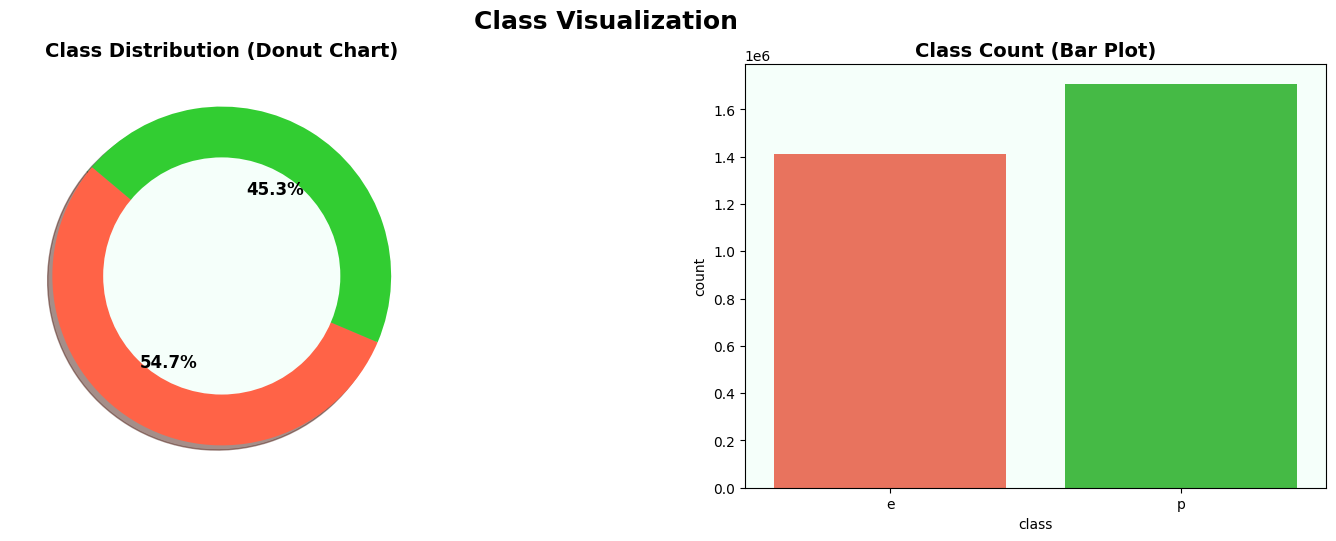

In [9]:
# Custom color palette specifically for the 'class' column
class_palette = sns.color_palette(['#FF6347', '#32CD32'])  # Using tomato red and lime green to represent classes

# Plotting the 'class' variable
f, ax = plt.subplots(1, 2, figsize=(18, 5.5))

# Donut chart for 'class' distribution
wedges, texts, autotexts = ax[0].pie(train['class'].value_counts(), autopct='%1.1f%%', shadow=True, colors=class_palette, startangle=140, wedgeprops=dict(width=0.4))
ax[0].set_ylabel('')
ax[0].set_title(f'Class Distribution (Donut Chart)', fontsize=14, fontweight='bold')
ax[0].set_facecolor('#F5FFFA')
center_circle = plt.Circle((0, 0), 0.70, fc='#F5FFFA')  # Adding a circle at the center to create the donut
ax[0].add_artist(center_circle)

# Set label and percentage text colors to black
for text in texts:
    text.set_fontsize(12)
    text.set_color('black')  # Change label text color to black
for autotext in autotexts:
    autotext.set_fontsize(12)
    autotext.set_color('black')  # Change percentage text color to black
    autotext.set_weight('bold')

# Bar plot for 'class' distribution
sns.countplot(x='class', data=train, ax=ax[1], palette=class_palette)
ax[1].set_title(f'Class Count (Bar Plot)', fontsize=14, fontweight='bold')
ax[1].set_facecolor('#F5FFFA')

plt.suptitle(f'Class Visualization', fontsize=18, fontweight='bold')
plt.subplots_adjust(wspace=0.4)  # Adjust space between plots
plt.show()

## Data Visualzation 📊📈

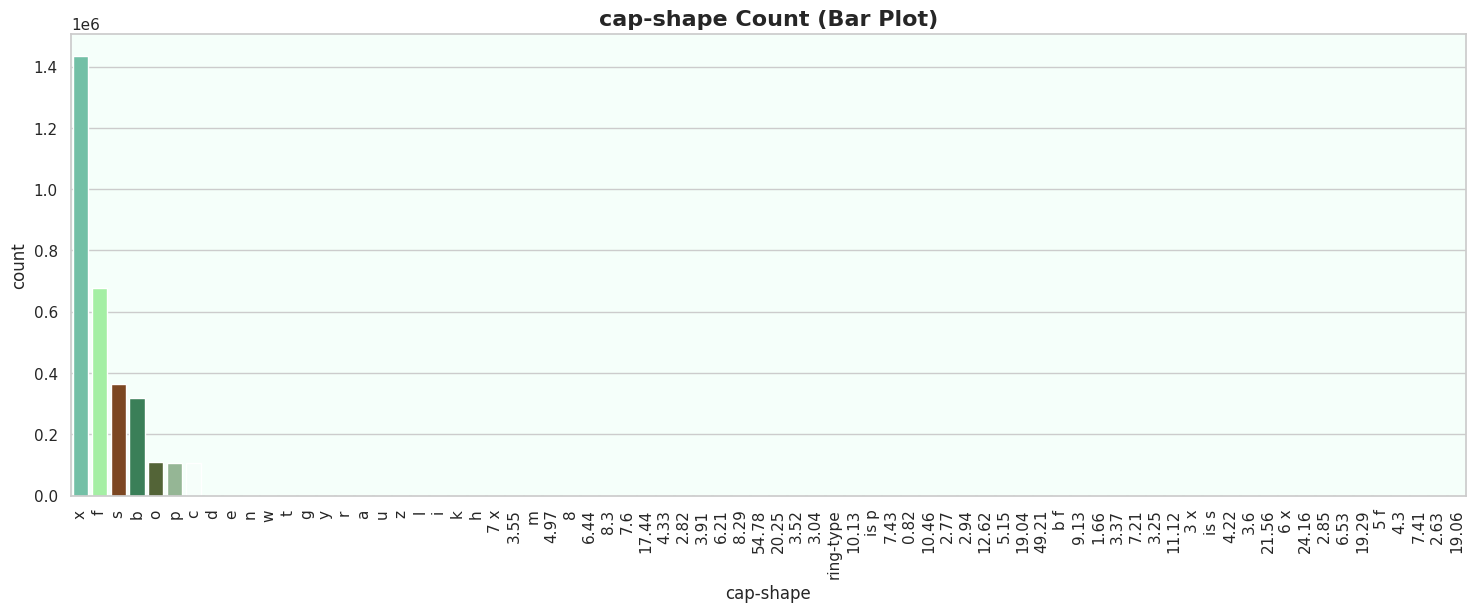

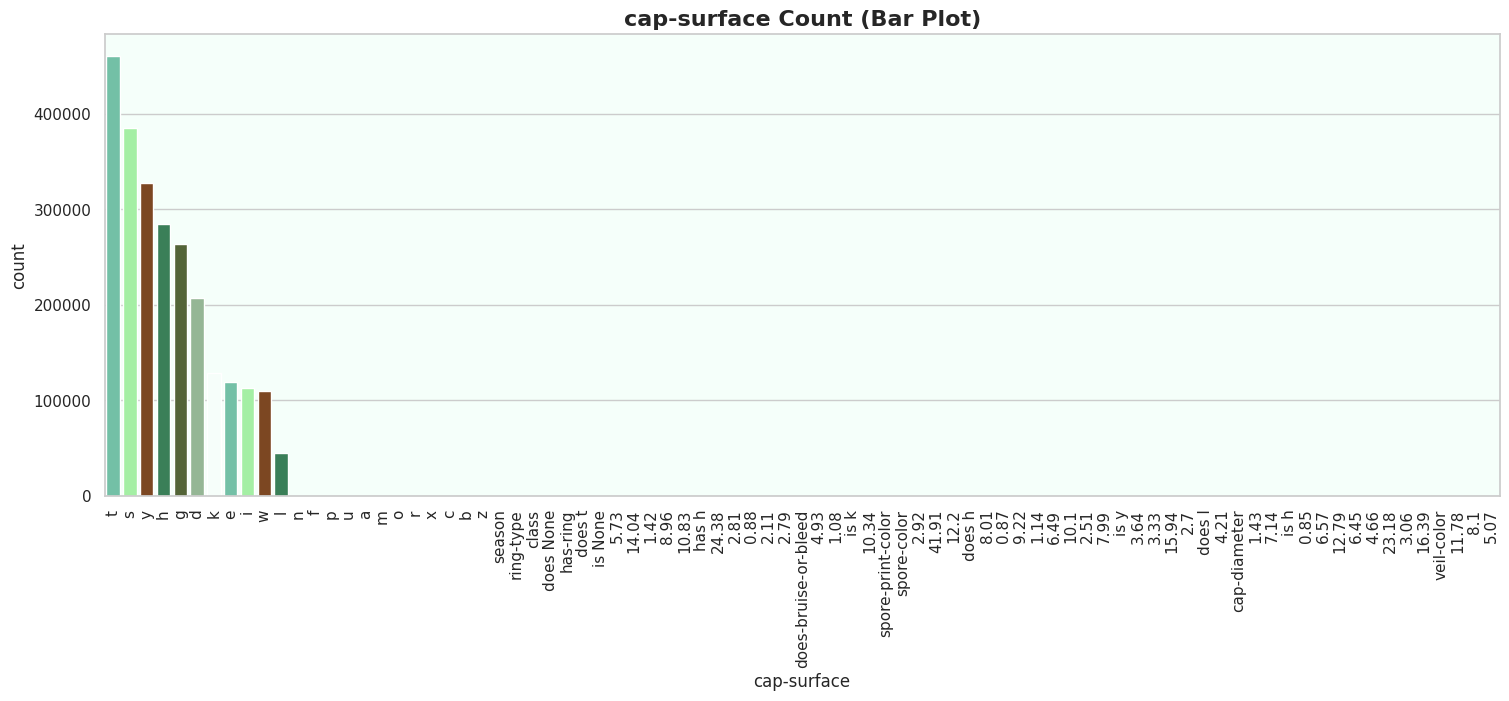

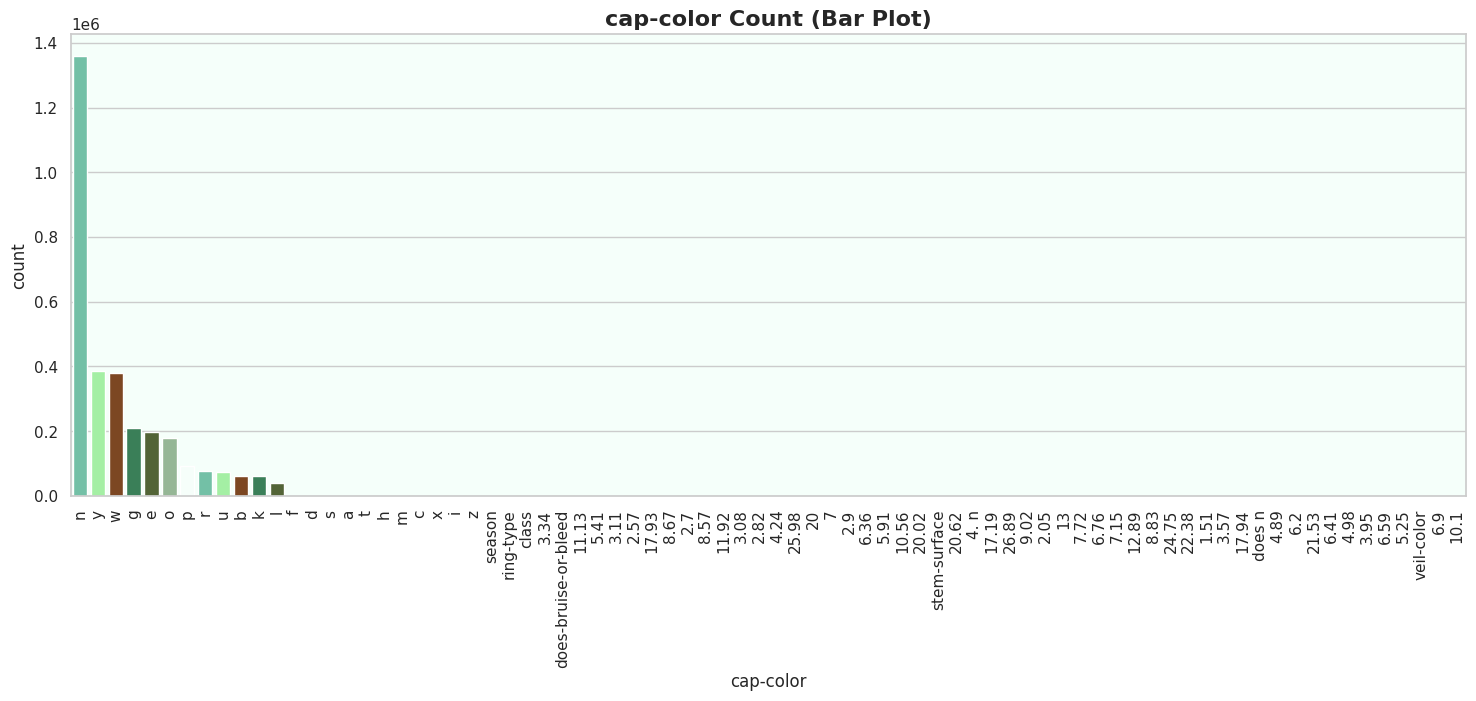

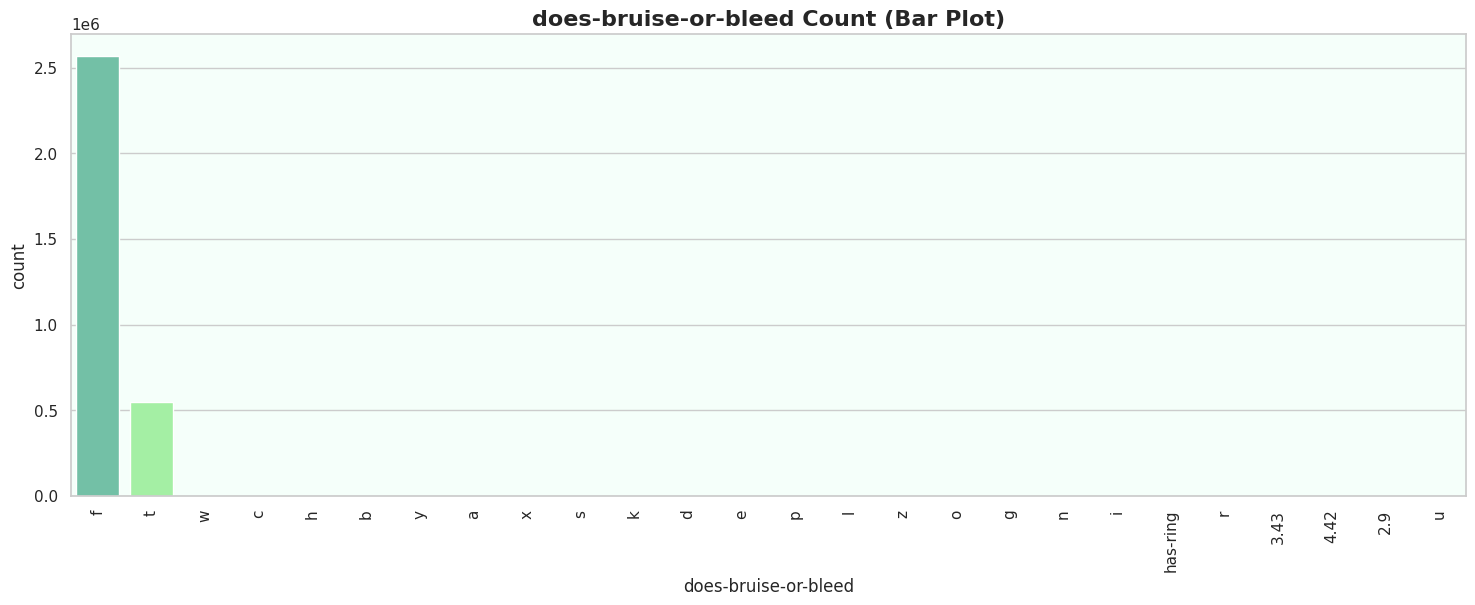

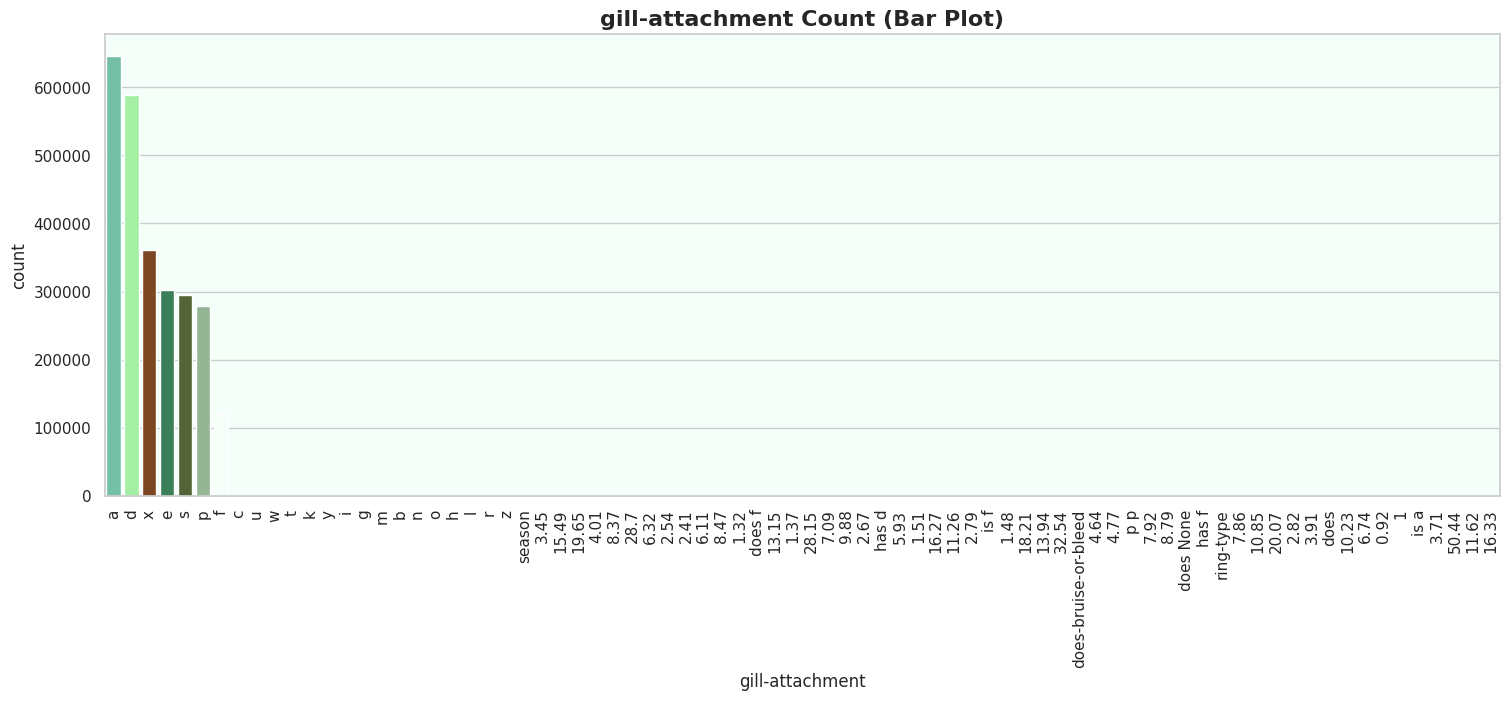

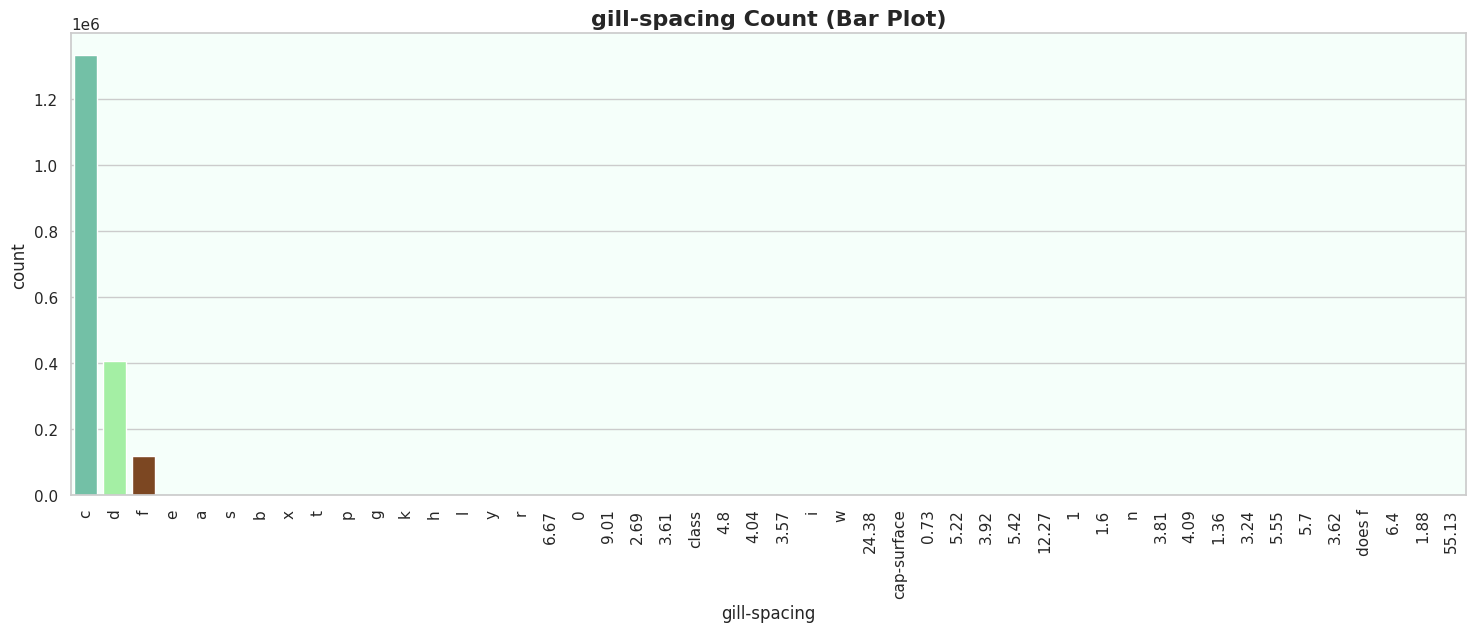

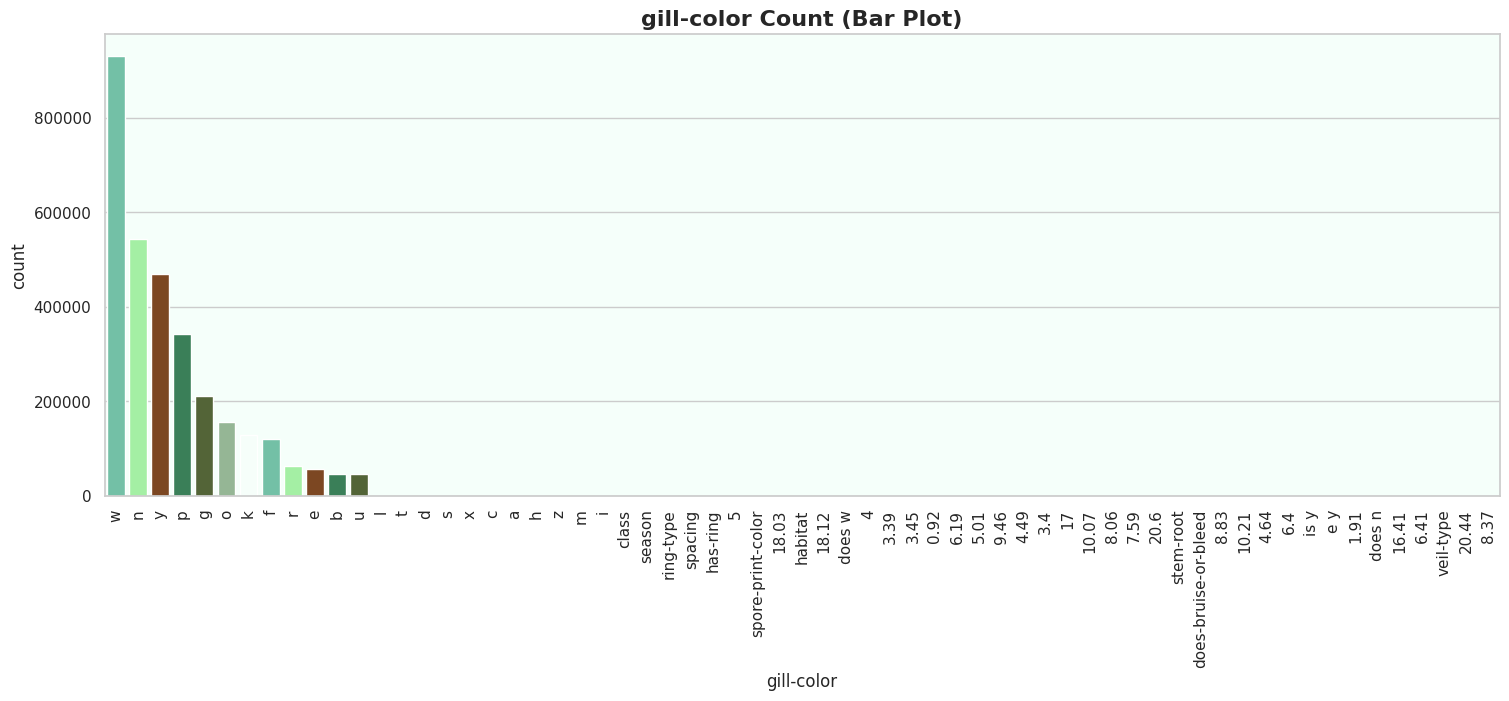

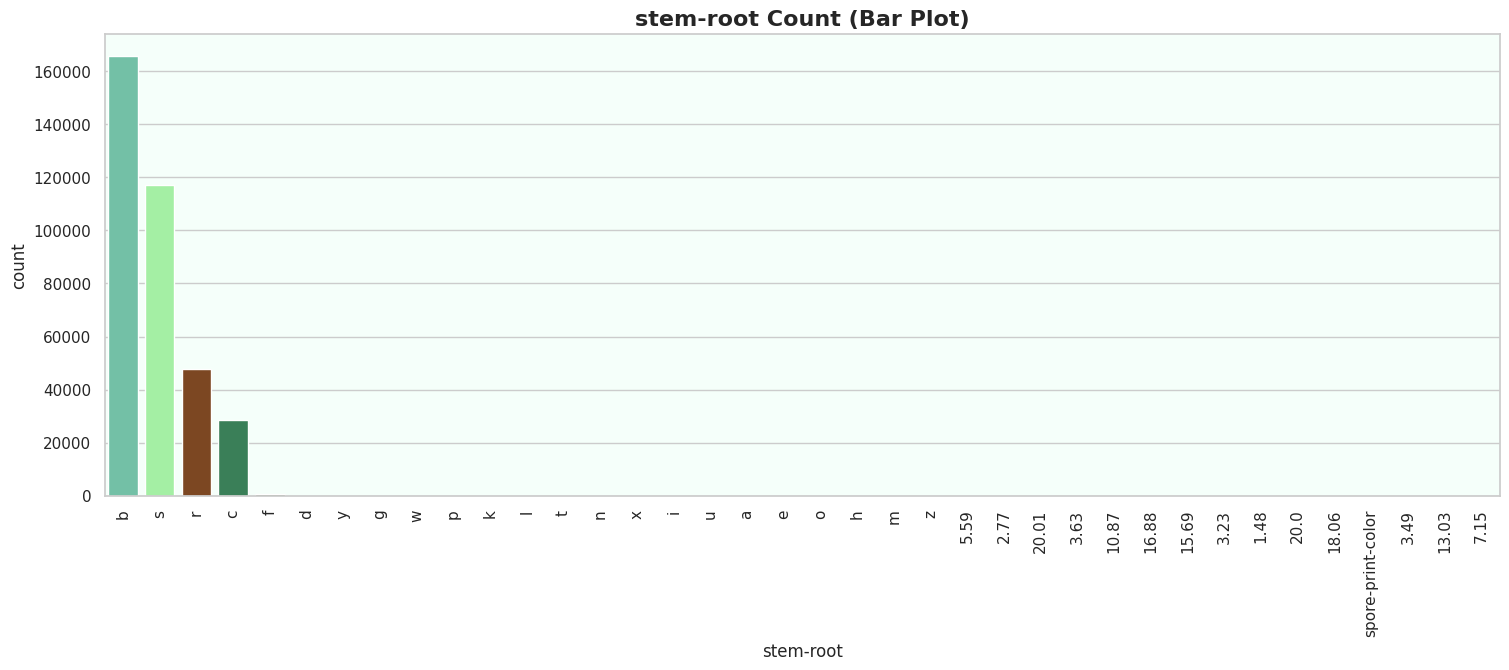

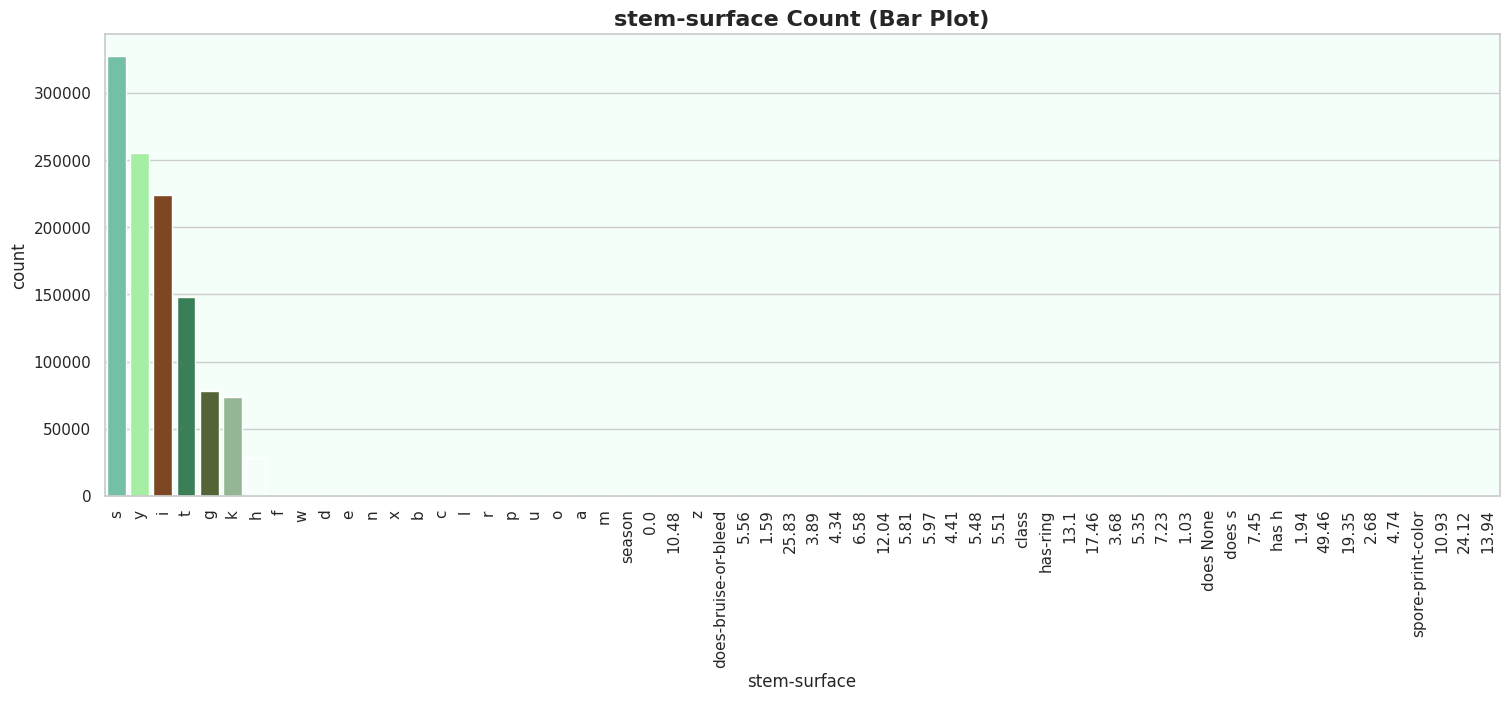

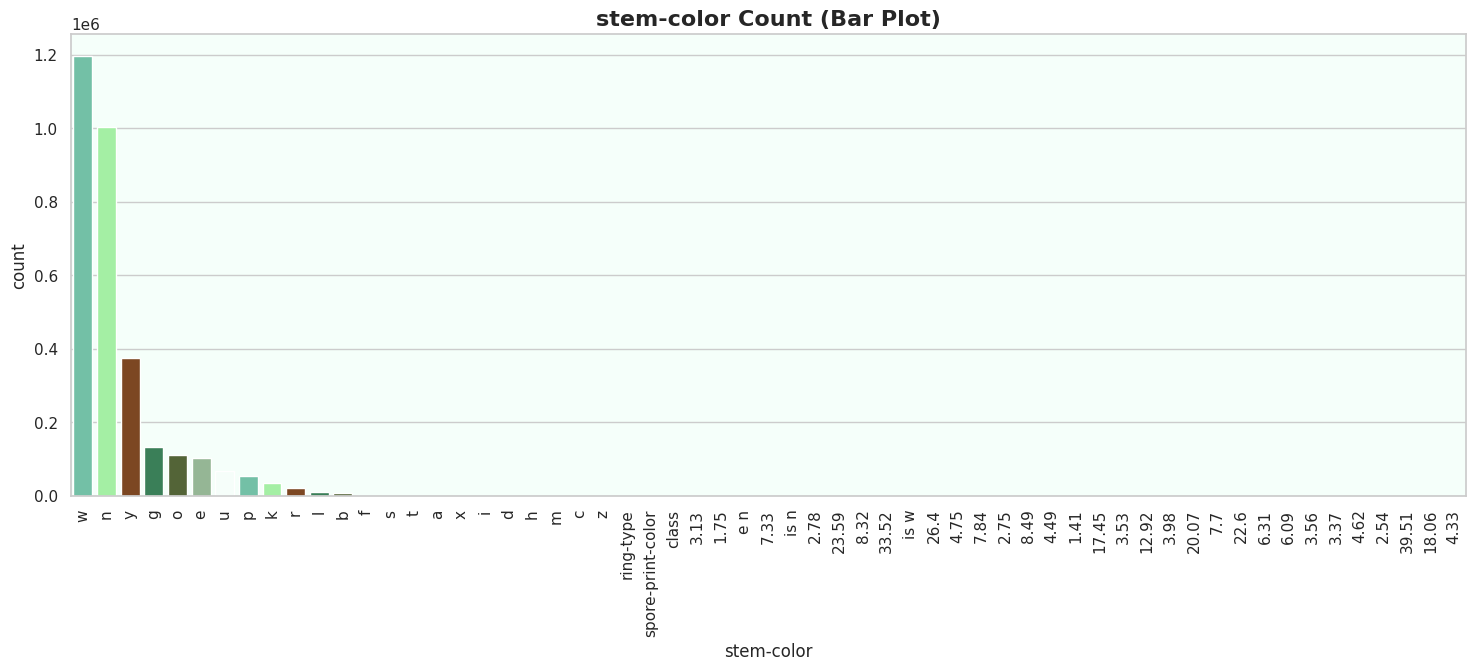

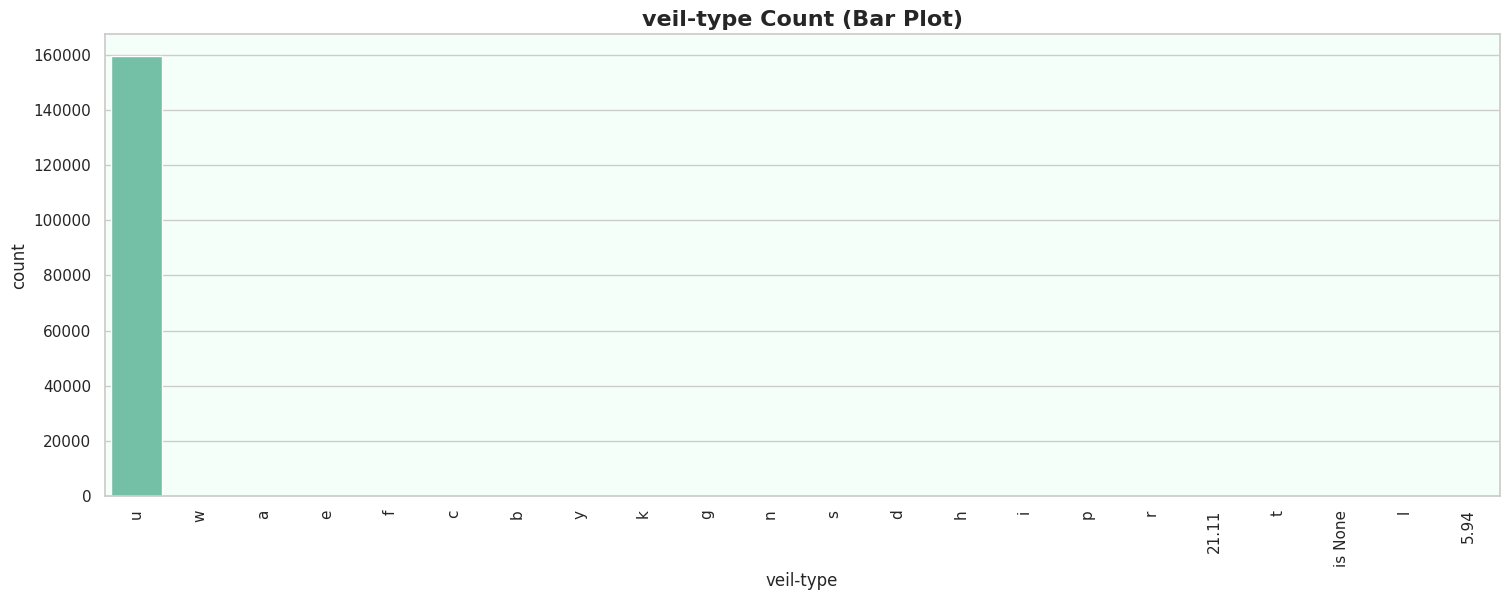

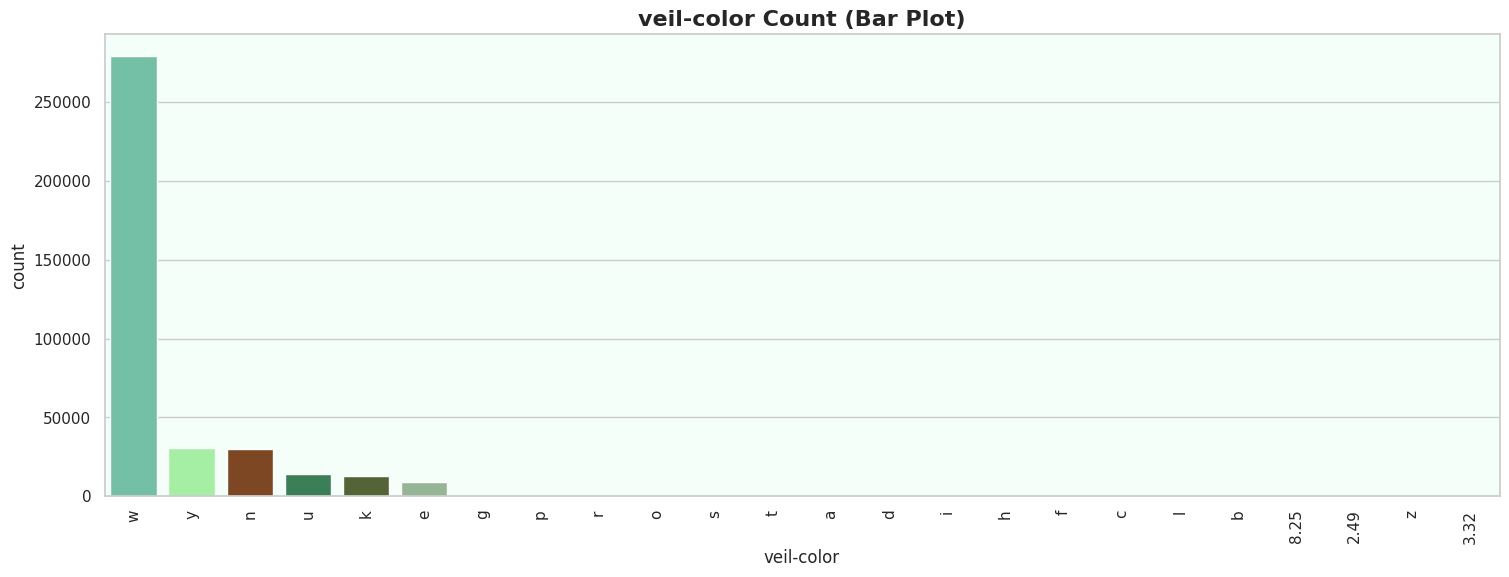

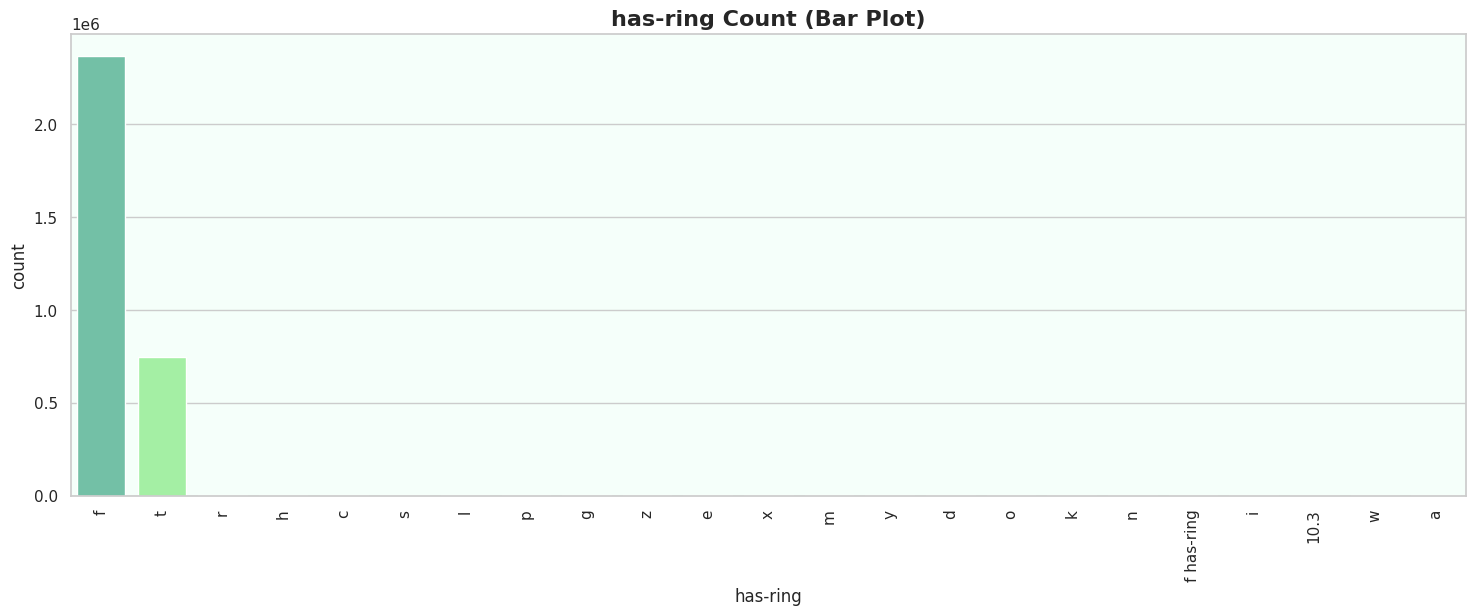

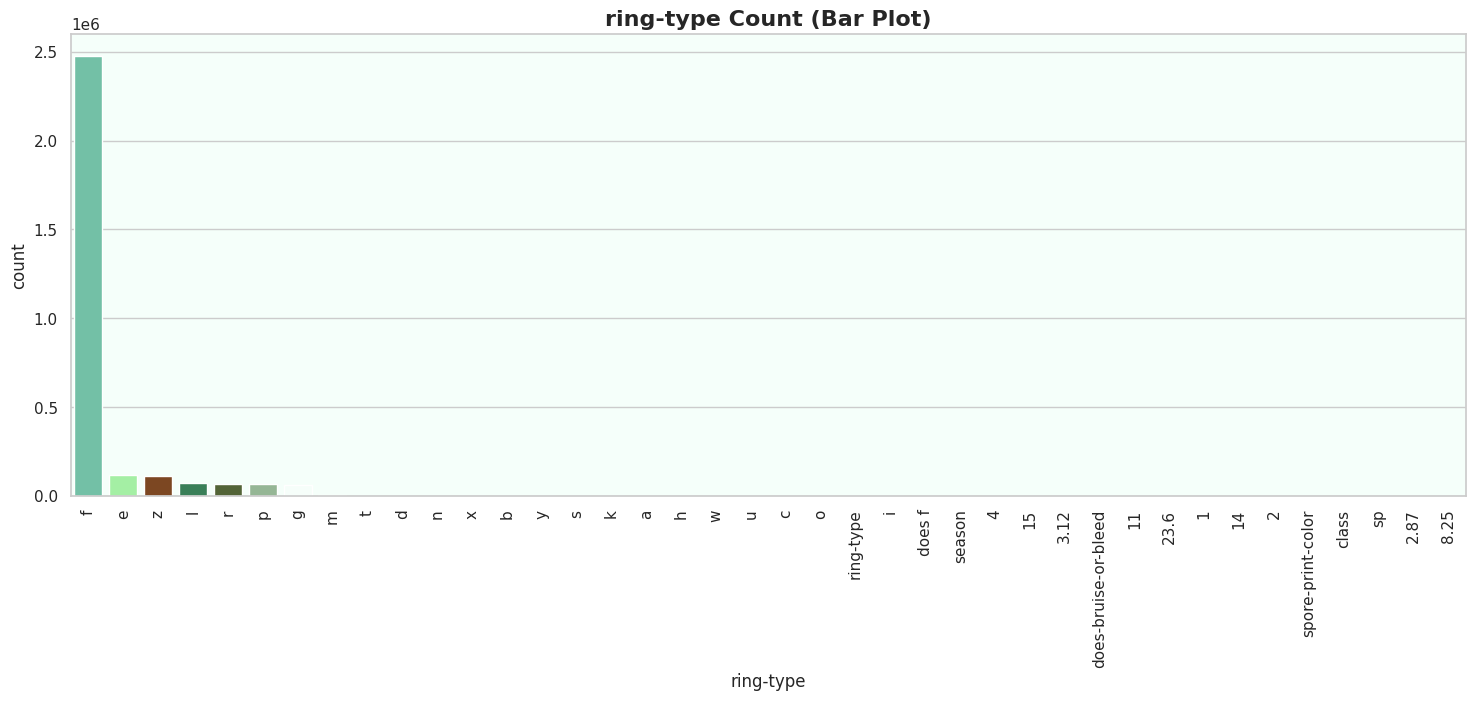

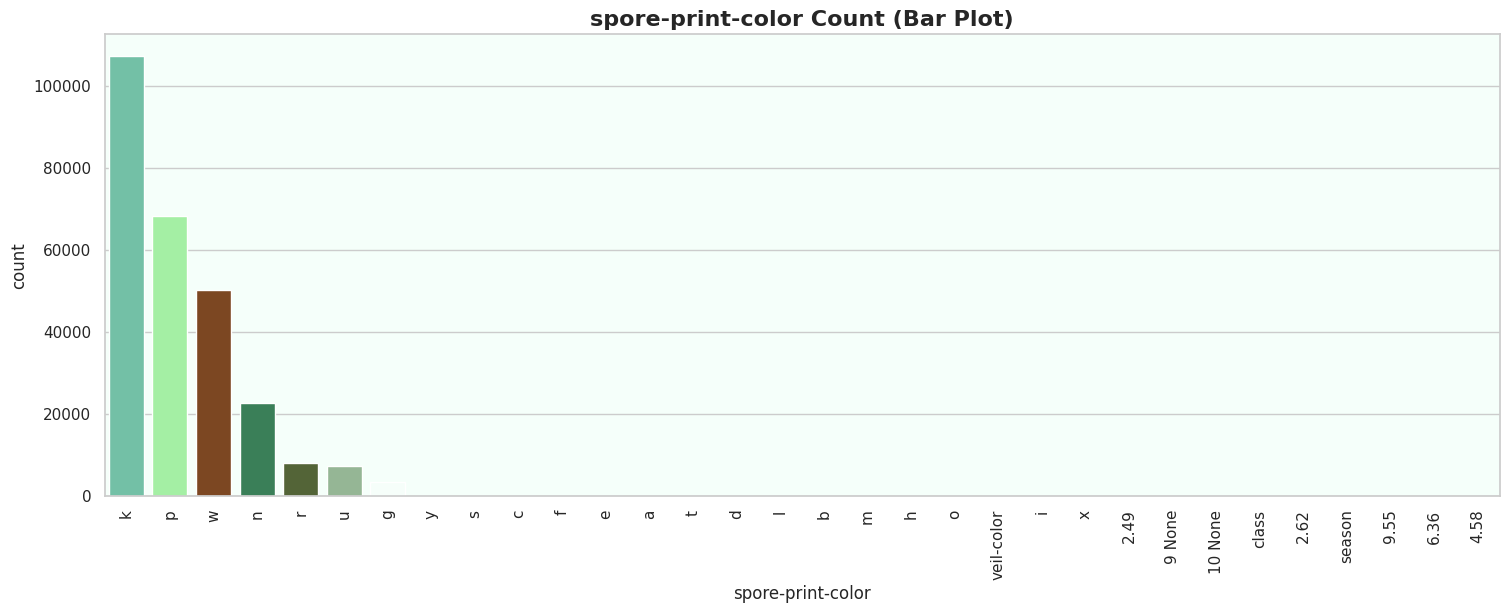

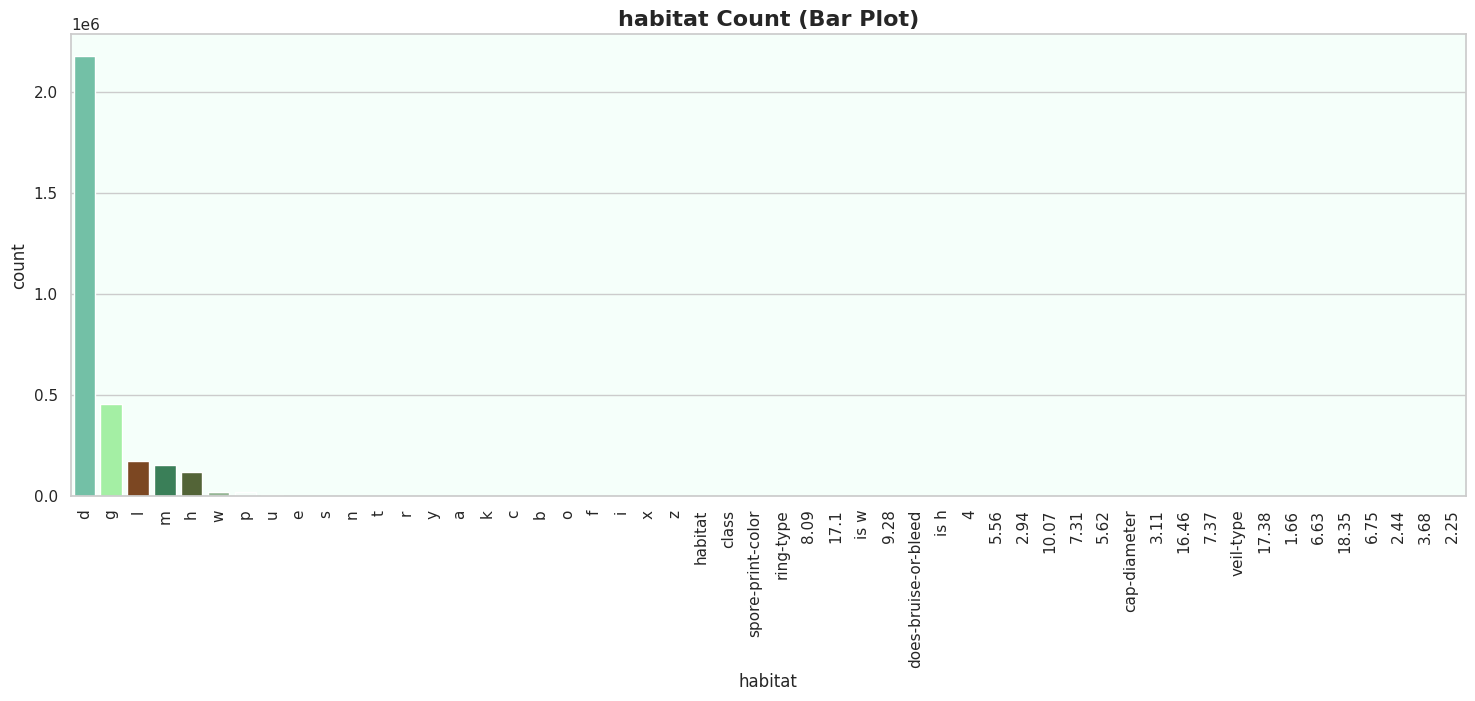

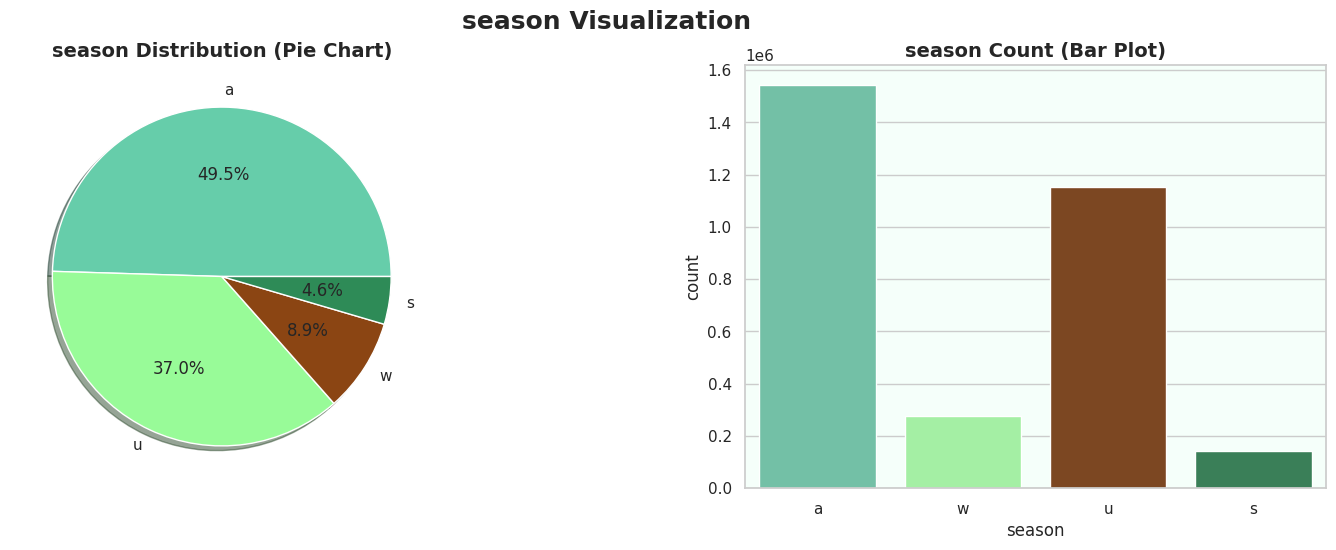

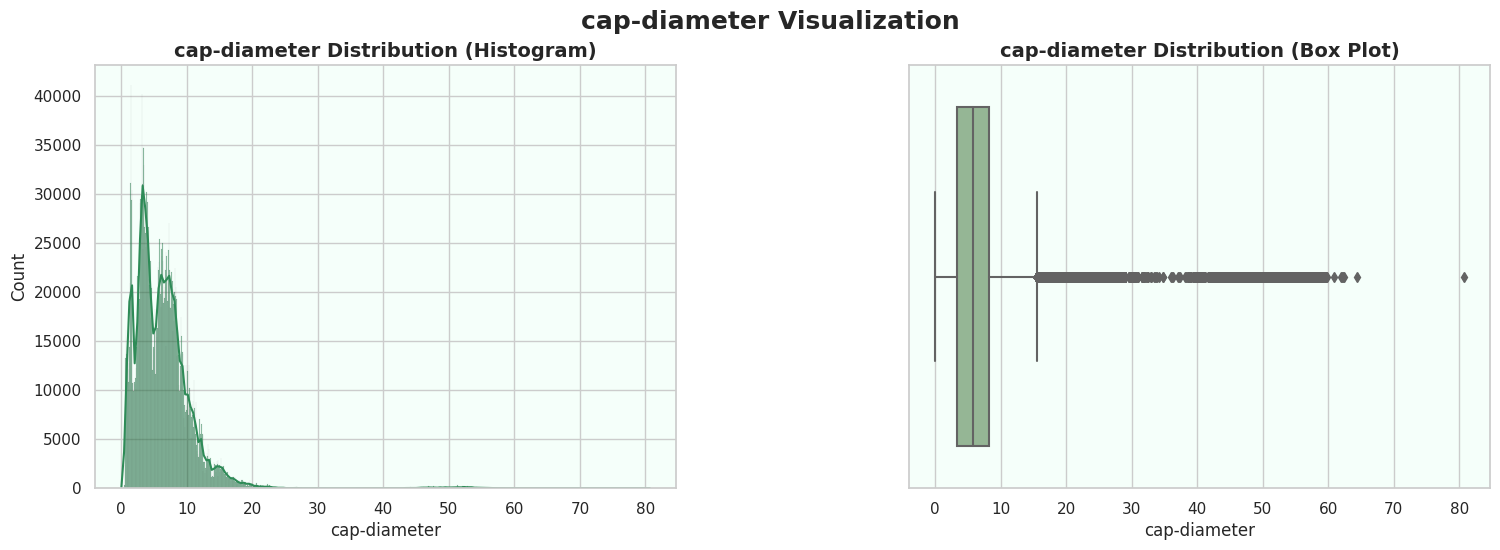

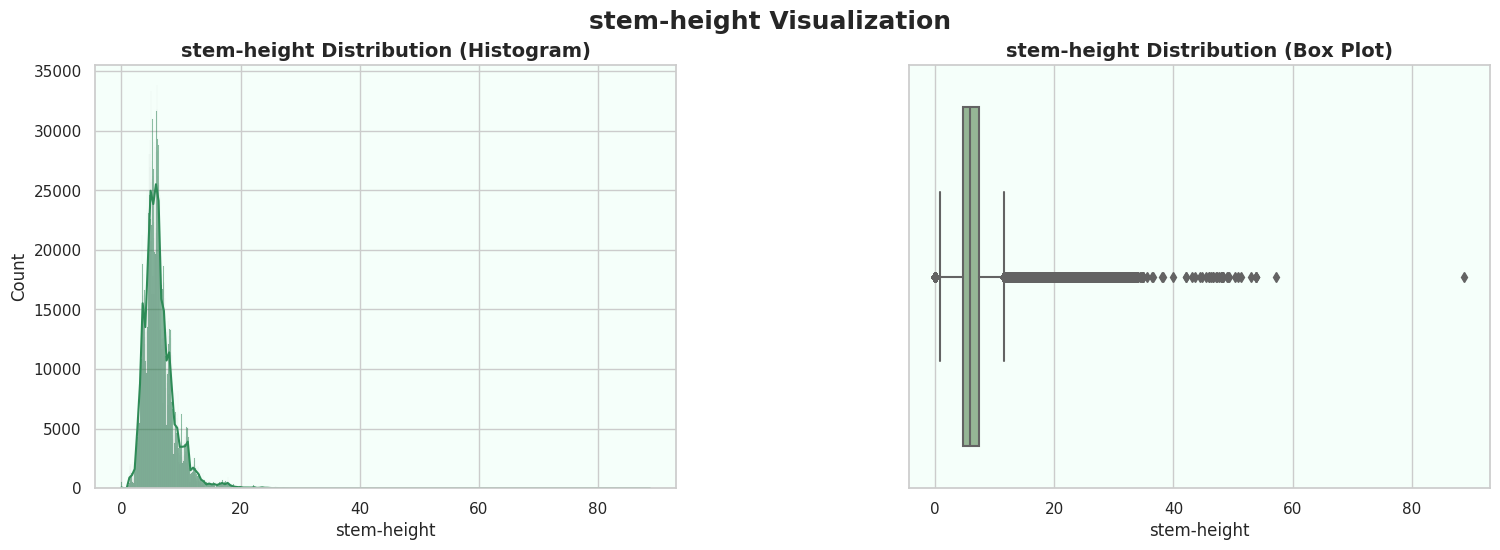

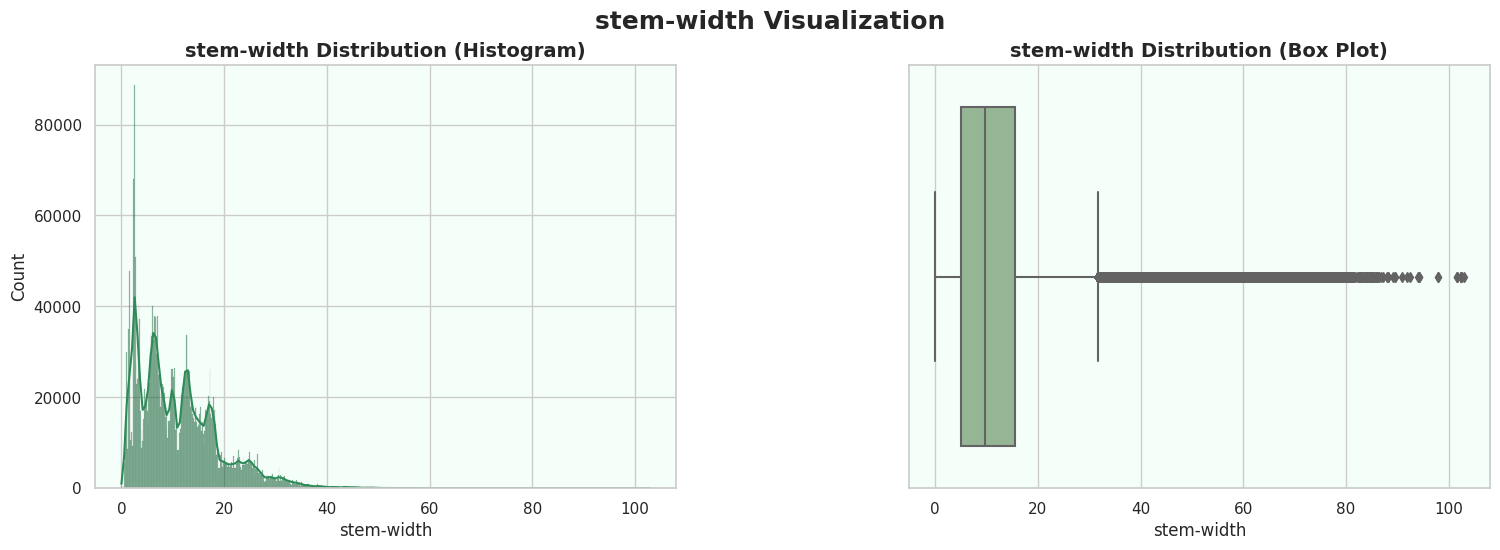

In [10]:
# Custom color palette for mushroom-related visuals
custom_palette = sns.color_palette(['#66CDAA', '#98FB98', '#8B4513', '#2E8B57', '#556B2F', '#8FBC8F', '#F5FFFA'])

# Set a general aesthetic style for the plots
sns.set(style="whitegrid")

# Visualize Categorical Variables
for column in categorical_features:
    if train[column].nunique() <= 20:  # Only plot pie charts for features with <= 20 unique values
        f, ax = plt.subplots(1, 2, figsize=(18, 5.5))
        train[column].value_counts().plot.pie(autopct='%1.1f%%', ax=ax[0], shadow=True, colors=custom_palette)
        ax[0].set_ylabel('')
        ax[0].set_title(f'{column} Distribution (Pie Chart)', fontsize=14, fontweight='bold')
        ax[0].set_facecolor('#F5FFFA')  # Set background color for better contrast
        sns.countplot(x=column, data=train, ax=ax[1], palette=custom_palette)
        ax[1].set_title(f'{column} Count (Bar Plot)', fontsize=14, fontweight='bold')
        ax[1].set_facecolor('#F5FFFA')
        plt.suptitle(f'{column} Visualization', fontsize=18, fontweight='bold')
        plt.subplots_adjust(wspace=0.4)  # Adjust space between plots
        plt.show()
    else:  # For columns with more unique values, use only bar plot
        plt.figure(figsize=(18, 6))
        sns.countplot(x=column, data=train, palette=custom_palette, order=train[column].value_counts().index)
        plt.title(f'{column} Count (Bar Plot)', fontsize=16, fontweight='bold')
        plt.xticks(rotation=90)
        plt.gca().set_facecolor('#F5FFFA')
        plt.show()

# Visualize Numerical Variables
for column in numerical_features:
    f, ax = plt.subplots(1, 2, figsize=(18, 5.5))
    sns.histplot(train[column], ax=ax[0], kde=True, color=custom_palette[3], edgecolor='black')
    sns.boxplot(x=train[column], ax=ax[1], color=custom_palette[5])
    ax[0].set_title(f'{column} Distribution (Histogram)', fontsize=14, fontweight='bold')
    ax[1].set_title(f'{column} Distribution (Box Plot)', fontsize=14, fontweight='bold')
    ax[0].set_facecolor('#F5FFFA')
    ax[1].set_facecolor('#F5FFFA')
    plt.suptitle(f'{column} Visualization', fontsize=18, fontweight='bold')
    plt.subplots_adjust(wspace=0.4)  # Adjust space between plots
    plt.show()

# Create DataFrames for numerical and categorical variables
df_numerical = pd.DataFrame({'Numerical Variables': numerical_features})
df_categorical = pd.DataFrame({'Categorical Variables': categorical_features})

## Searching for Missing Values 🕵️


In [11]:
train.isna().sum()

class                         0
cap-diameter                  4
cap-shape                    40
cap-surface              671023
cap-color                    12
does-bruise-or-bleed          8
gill-attachment          523936
gill-spacing            1258435
gill-color                   57
stem-height                   0
stem-width                    0
stem-root               2757023
stem-surface            1980861
stem-color                   38
veil-type               2957493
veil-color              2740947
has-ring                     24
ring-type                128880
spore-print-color       2849682
habitat                      45
season                        0
dtype: int64

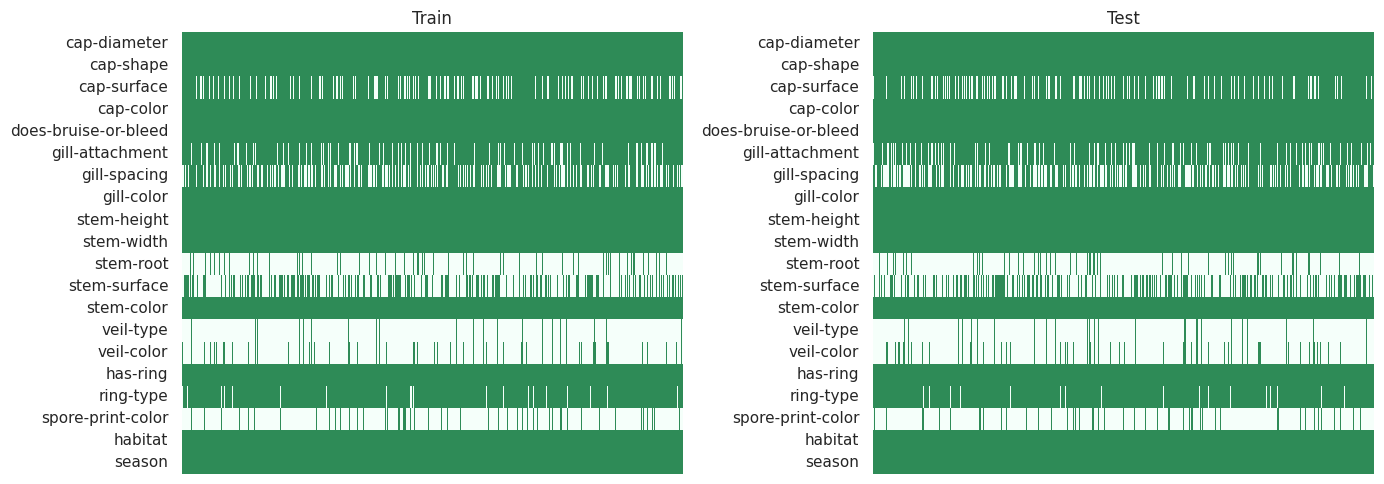

In [12]:
# Custom color palette
custom_palette = ['#2E8B57', '#98FB98', '#8B4513', '#2E8B57', '#556B2F', '#8FBC8F', '#F5FFFA']

# Create a custom colormap
cmap = LinearSegmentedColormap.from_list("custom_cmap", custom_palette, N=256)

# Sample data for null values heatmap
train_null_values = train.sample(100_000).drop(columns=['class']).isnull().T
test_null_values = test.sample(100_000).isnull().T

# Plotting the heatmaps
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 5))

sns.heatmap(train_null_values, cbar=False, cmap=cmap, ax=axes[0])
axes[0].set_title('Train')
axes[0].set_xticks([]) 
axes[0].set_xlabel('')

sns.heatmap(test_null_values, cbar=False, cmap=cmap, ax=axes[1])
axes[1].set_title('Test')
axes[1].set_xticks([]) 
axes[1].set_xlabel('')

plt.tight_layout()
plt.show()

In [13]:
features = train.drop('class', axis=1).columns.to_list()

features_with_high_null_values = [feature for feature in features if (train[feature].isna().sum()/len(train)*100)>20]
df_features_high_null = pd.DataFrame(features_with_high_null_values, columns=['Features With High Null Values'])

# Apply styling to the DataFrame
df_features_high_null = style_dataframe(df_features_high_null)

# Display the styled DataFrame
df_features_high_null

Features With High Null Values
cap-surface
gill-spacing
stem-root
stem-surface
veil-type
veil-color
spore-print-color


## Feature Engineering 🛠️ 

In [14]:
cat_features = test.select_dtypes('object').columns

In [15]:
# Reference: https://www.kaggle.com/code/ambrosm/pss4e8-eda-which-makes-sense
for feature in cat_features:          
    categories = sorted(list(set(original[feature].dropna())))
    dtype = pd.CategoricalDtype(categories=categories, ordered=False)
    
    train.loc[~train[feature].isin(categories), feature] = np.nan
    test.loc[~test[feature].isin(categories), feature] = np.nan
    
    train[feature] = train[feature].astype(dtype)
    test[feature] = test[feature].astype(dtype)

<h2 style="text-align: center; font-size: 24px; color: #3A6AB7; font-family: 'Comic Sans MS', cursive;">Model Training and Optimization</h2>
<p style="text-align: center; font-size: 20px; background-color: #90EE90; font-family: 'Comic Sans MS', cursive; padding: 20px; border-radius: 10px; box-shadow: 0 4px 6px rgba(0, 0, 0, 0.1); color: #3A6AB7;">
   In this section, we train an Ensemble model (XBG + LGBM) to predict outcomes based on our dataset. We fine-tune the model through hyperparameter optimization to achieve the best performance. After training, we generate predictions and prepare the results for submission, ensuring our model's predictions are accurately formatted and ready for evaluation.
</p>


In [16]:
X = train.drop([TARGET], axis=1)
y = train[TARGET].map({'e': 0, 'p': 1})
X_test = test

## Memory Optimization 🧮


In [17]:
def reduce_memory_usage(dataframe):        
    print('Reducing memory usage')
    initial_mem_usage = dataframe.memory_usage().sum() / 1024**2
    
    for col in dataframe.columns:
        col_type = dataframe[col].dtype

        if col_type.name in ['category', 'object']:
            continue

        c_min = dataframe[col].min()
        c_max = dataframe[col].max()
        if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
            dataframe[col] = dataframe[col].astype(np.float16)
        elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
            dataframe[col] = dataframe[col].astype(np.float32)
        else:
            dataframe[col] = dataframe[col].astype(np.float64)

    final_mem_usage = dataframe.memory_usage().sum() / 1024**2
    print('--- Memory usage before: {:.2f} MB'.format(initial_mem_usage))
    print('--- Memory usage after: {:.2f} MB'.format(final_mem_usage))
    print('--- Decreased memory usage by {:.1f}%\n'.format(100 * (initial_mem_usage - final_mem_usage) / initial_mem_usage))

    return dataframe

In [18]:
X = reduce_memory_usage(X)
X_test = reduce_memory_usage(X_test)

Reducing memory usage
--- Memory usage before: 210.16 MB
--- Memory usage after: 156.65 MB
--- Decreased memory usage by 25.5%

Reducing memory usage
--- Memory usage before: 97.11 MB
--- Memory usage after: 61.44 MB
--- Decreased memory usage by 36.7%



## Model Training ⚙️

In [19]:
def mcc(y_true, y_pred):
    y_pred_binary = np.round(y_pred) 
    mcc = matthews_corrcoef(y_true, y_pred_binary)
    return 'MCC', mcc, True 

In [20]:
class Trainer:
    def __init__(self, models, n_folds=N_FOLDS):
        self.models = models  # List of models
        self.n_folds = n_folds

    def fit_predict(self, X, y, X_test):
        print(f'Training ensemble of {len(self.models)} models\n')
        
        scores = []        
        oof_pred_probs = np.zeros((X.shape[0], len(np.unique(y))))
        test_pred_probs = np.zeros((X_test.shape[0], len(np.unique(y))))
        
        skf = StratifiedKFold(n_splits=self.n_folds, random_state=SEED, shuffle=True)
        for fold_idx, (train_idx, val_idx) in enumerate(skf.split(X, y)):
            X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
            y_train, y_val = y[train_idx], y[val_idx]
            
            fold_oof_pred_probs = np.zeros((len(val_idx), len(np.unique(y))))
            fold_test_pred_probs = np.zeros((X_test.shape[0], len(np.unique(y))))
            
            for model in self.models:
                model_instance = clone(model)
                
                # Fit the XGBoost model with verbose
                if isinstance(model_instance, XGBClassifier):
                    model_instance.fit(
                        X_train, 
                        y_train, 
                        eval_set=[(X_val, y_val)],
                        verbose=ES_LOG_STEPS
                    )
                
                # Fit the LGBM model with callbacks for verbosity and early stopping
                elif isinstance(model_instance, LGBMClassifier):
                    model_instance.fit(
                        X_train, 
                        y_train, 
                        eval_set=[(X_val, y_val)], 
                        eval_metric=mcc,
                        callbacks=[
                            log_evaluation(period=ES_LOG_STEPS), 
                            early_stopping(stopping_rounds=ES_ROUNDS, verbose=True)
                        ]
                    )
                
                # Predictions
                y_pred_probs = model_instance.predict_proba(X_val)
                fold_oof_pred_probs += y_pred_probs / len(self.models)  # Averaging predictions
                
                temp_test_pred_probs = model_instance.predict_proba(X_test)
                fold_test_pred_probs += temp_test_pred_probs / len(self.models)  # Averaging test predictions

                del model_instance, y_pred_probs, temp_test_pred_probs
                gc.collect()

            oof_pred_probs[val_idx] = fold_oof_pred_probs
            test_pred_probs += fold_test_pred_probs / self.n_folds  # Averaging across folds
            
            y_preds = fold_oof_pred_probs[:, 1] >= THRESHOLD
            score = matthews_corrcoef(y_val, y_preds)
            scores.append(score)
            
            print(f'\n--- Fold {fold_idx + 1} - MCC: {score:.6f}\n\n')
            
        self._save_pred_probs(oof_pred_probs, np.mean(scores), 'oof')
        self._save_pred_probs(test_pred_probs, np.mean(scores), 'test')
        self._save_submission(test_pred_probs, np.mean(scores))
        print(f'------ Average MCC: {np.mean(scores):.6f} ± {np.std(scores):.6f}\n\n')

    # Saving Predictions        
    def _save_pred_probs(self, pred_probs, cv_score, name):
        model_names = "_".join([model.__class__.__name__.lower().replace('classifier', '') for model in self.models])
        with open(f'{model_names}_{name}_pred_probs_{cv_score:.6f}.pkl', 'wb') as f:
            pickle.dump(pred_probs, f)

    # Saving Submission    
    def _save_submission(self, test_pred_probs, score):
        model_names = "_".join([model.__class__.__name__.lower().replace('classifier', '') for model in self.models])
        sub = pd.read_csv('/kaggle/input/playground-series-s4e8/sample_submission.csv')
        
        subm = pd.read_csv('/kaggle/input/playground-series-s4e8/sample_submission.csv')
        subm[TARGET] = test_pred_probs[:, 1] >= THRESHOLD
        subm[TARGET] = subm[TARGET].map({False: 'e', True: 'p'})
        S = subm[TARGET].ravel()

        #Ensemble Solution
        
        S1 = pd.read_csv("/kaggle/input/autogloun-t8-dslanders/submission.csv")[TARGET].ravel()
        S2 = pd.read_csv("/kaggle/input/mario-s-nightmare-denselight-0-990/submission_test7.csv")[TARGET].ravel()
        S3 = pd.read_csv("/kaggle/input/ps4e8-binary-class-mathews-correlation-coeff/submission.csv")[TARGET].ravel()
        S4 = pd.read_csv("/kaggle/input/0-98530-can-you-eat/submission.csv")[TARGET].ravel()
        S5 = pd.read_csv("/kaggle/input/playgrounds4e08-modeblend/submission.csv")[TARGET].ravel()
        S6 = pd.read_csv("/kaggle/input/mario-s-nightmare-15-th-place-solution/submission.csv")[TARGET].ravel()
        preds = [S, S1, S2, S3, S4,S5,S6]
        
        # Label encode the predictions
        lab_enc = LabelEncoder()
        # Fit the encoder on the unique classes 'e' and 'p'
        lab_enc.fit(['e', 'p'])
        
        # Encode each set of predictions
        encoded_preds = [lab_enc.transform(pred) for pred in preds]

        # Convert encoded_preds to a numpy array for easier processing
        encoded_preds = np.array(encoded_preds)

        # Get the mode along the columns (axis=0)
        mode_preds = mode(encoded_preds, axis=0)[0].ravel()  # This gives the most common prediction

        # Decode the numerical labels back to 'e' and 'p'
        sub[TARGET] = lab_enc.inverse_transform(mode_preds)
        
        sub.to_csv(f'sub_{model_names}_{score:.6f}.csv', index=False)

In [21]:
xgb_params = {
    "colsample_bylevel": 0.9268202748354142,
    "colsample_bynode": 0.9584021138317574,
    "colsample_bytree": 0.5015612007146208,
    "early_stopping_rounds": ES_ROUNDS,  
    "enable_categorical": True,
    "gamma": 0.3707206931090372,
    "grow_policy": "lossguide",
    "learning_rate": 0.03906159386409017,
    "max_depth": 16,
    "min_child_weight": 0.6117236350232369,
    "n_estimators": 5000,
    "n_jobs": -1,
    "random_state": SEED,
    "reg_alpha": 1.7264475728199302,
    "reg_lambda": 94.37990118781973,
    "subsample": 0.7599216762241778,
    "tree_method": "hist",
    "verbosity": 0
}

lgbm_params = {
    
    'colsample_bytree': 0.49938653455911297,
    'learning_rate': 0.019616165942899312,
    'max_bin': 2249,
    'min_child_samples': 156,
    'n_estimators': 5000,
    'n_jobs': -1,
    'num_leaves': 590,
    'random_state': SEED,
    'reg_alpha': 0.416272935775317,
    'reg_lambda': 86.59005784540076,
    'subsample': 0.7495711298182588,
    'verbose': -1
}

xgb_model = XGBClassifier(**xgb_params)
lgbm_model = LGBMClassifier(**lgbm_params)

# Create the trainer with both models
trainer = Trainer(models=[xgb_model, lgbm_model])

# Train and predict
trainer.fit_predict(X, y, X_test)

Training ensemble of 2 models

[0]	validation_0-logloss:0.65511
[100]	validation_0-logloss:0.05318
[200]	validation_0-logloss:0.03778
[300]	validation_0-logloss:0.03652
[400]	validation_0-logloss:0.03617
[500]	validation_0-logloss:0.03603
[600]	validation_0-logloss:0.03594
[700]	validation_0-logloss:0.03589
[800]	validation_0-logloss:0.03585
[900]	validation_0-logloss:0.03584
[1000]	validation_0-logloss:0.03583
[1100]	validation_0-logloss:0.03583
[1134]	validation_0-logloss:0.03583
Training until validation scores don't improve for 100 rounds
[100]	valid_0's binary_logloss: 0.121856	valid_0's MCC: 0.982665
[200]	valid_0's binary_logloss: 0.0529143	valid_0's MCC: 0.983158
[300]	valid_0's binary_logloss: 0.0407408	valid_0's MCC: 0.983447
[400]	valid_0's binary_logloss: 0.0377858	valid_0's MCC: 0.983876
[500]	valid_0's binary_logloss: 0.0368675	valid_0's MCC: 0.9841
[600]	valid_0's binary_logloss: 0.036475	valid_0's MCC: 0.984271
[700]	valid_0's binary_logloss: 0.0362824	valid_0's MCC: 0.

**References**

1. [Mushroom Classification using XGBoost](https://www.kaggle.com/code/ravaghi/s04e08-mushroom-classification-xgboost?scriptVersionId=193232491)
2. [Binary Prediction of Poisonous Mushrooms using XGBoost](https://www.kaggle.com/code/danishyousuf19/binary-prediction-of-poisonous-mushrooms-xgb)
3. [Mushrooms - Trying Different Models with AutoGluon](https://www.kaggle.com/code/crisbebop/mushrooms-trying-differents-models-w-autogluon)
4. [0.98527 - Can You Eat?](https://www.kaggle.com/code/darkdevil18/0-98527-can-you-eat/notebook#Submission)
5. [AutoGluon T8](https://www.kaggle.com/code/mobinapoulaei/autogloun-t8-dslanders)
6. [Mario's Nightmare - 15th Place Solution](https://www.kaggle.com/code/trupologhelper/mario-s-nightmare-15-th-place-solution)
7. [PS4E8 - Binary Class Mathews Correlation Coefficient](https://www.kaggle.com/code/arunklenin/ps4e8-binary-class-mathews-correlation-coeff)
8. [Mario's Nightmare DenseLight 0.990](https://www.kaggle.com/code/adaluodaa/mario-s-nightmare-denselight-0-990)



<p style="text-align: center; font-size: 20px; background-color: #90EE90; font-family: 'Comic Sans MS', cursive; padding: 20px; border-radius: 10px; box-shadow: 0 4px 6px rgba(0, 0, 0, 0.1); color: #3A6AB7;">
   This notebook explores the Mushroom dataset through detailed Exploratory Data Analysis (EDA) and feature engineering. We identify key patterns and prepare the data by handling different data types and finally we use an Ensemble model for prediction. If you found this notebook to be helpful, please consider giving an upvote! Thank you!
</p>
